Processing E:\newdata\img1.PNG
Noisy PSNR (P-G, Color): 29.36 dB
Noisy SSIM (P-G, Color): 0.3585
Denoised PSNR (P-G, Color): 35.28 dB
Denoised SSIM (P-G, Color): 0.8857


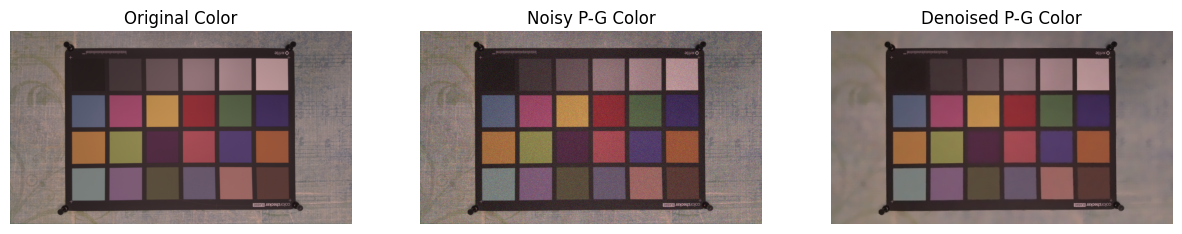

Processing E:\newdata\img2.PNG
Noisy PSNR (P-G, Color): 29.65 dB
Noisy SSIM (P-G, Color): 0.3665
Denoised PSNR (P-G, Color): 35.54 dB
Denoised SSIM (P-G, Color): 0.8682


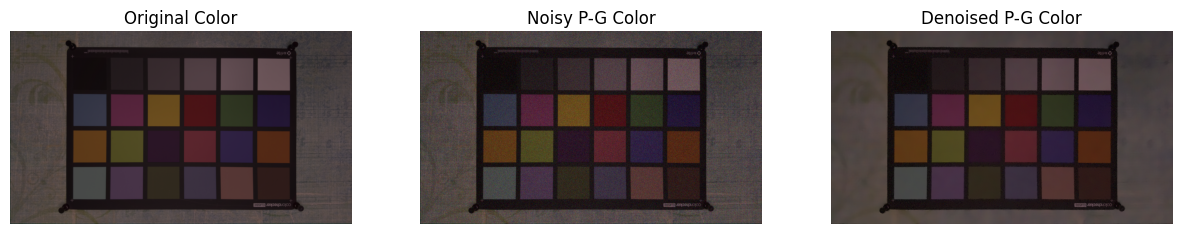

Processing E:\newdata\img3.PNG
Noisy PSNR (P-G, Color): 29.22 dB
Noisy SSIM (P-G, Color): 0.3725
Denoised PSNR (P-G, Color): 33.35 dB
Denoised SSIM (P-G, Color): 0.8541


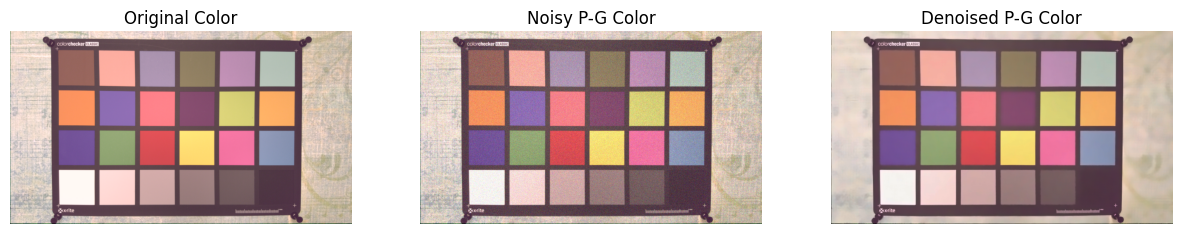

Processing E:\newdata\img4.PNG
Noisy PSNR (P-G, Color): 29.27 dB
Noisy SSIM (P-G, Color): 0.3547
Denoised PSNR (P-G, Color): 33.42 dB
Denoised SSIM (P-G, Color): 0.8138


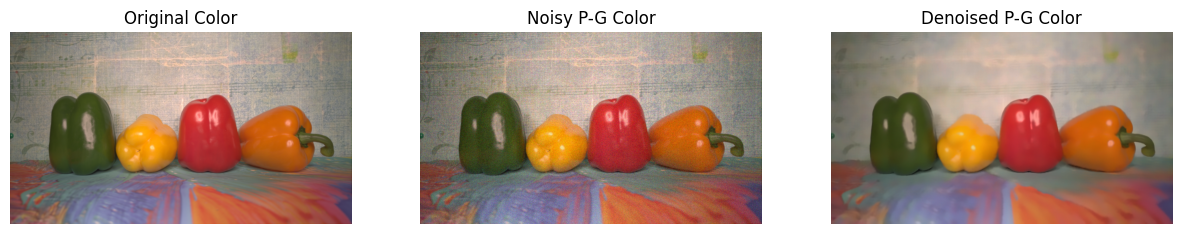

Processing E:\newdata\img5.PNG
Noisy PSNR (P-G, Color): 30.07 dB
Noisy SSIM (P-G, Color): 0.4274
Denoised PSNR (P-G, Color): 33.44 dB
Denoised SSIM (P-G, Color): 0.7562


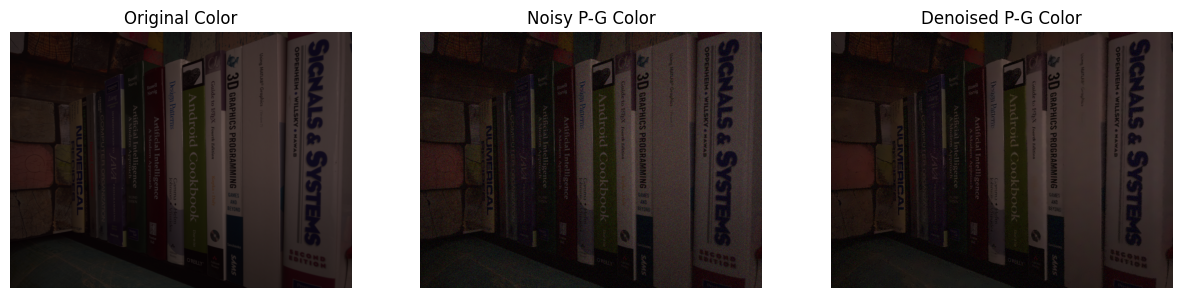

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

def psnr(original, noisy):
    mse = np.mean((original - noisy) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_value

def ssim(original, noisy):
    C1 = (0.01 * 255) ** 2
    C2 = (0.03 * 255) ** 2

    original = original.astype(np.float64)
    noisy = noisy.astype(np.float64)

    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(original, -1, window)[5:-5, 5:-5]
    mu2 = cv2.filter2D(noisy, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(original ** 2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(noisy ** 2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(original * noisy, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    ssim_value = ssim_map.mean()

    return ssim_value

def add_poisson_gaussian_noise(image, sigma_read=10):
    image = image.astype(np.float32) / 255.0
    noisy_image_poisson = np.random.poisson(image * 255) / 255.0
    noisy_image_poisson = np.clip(noisy_image_poisson * 255, 0, 255).astype(np.uint8)
    
    noisy_image_pg = noisy_image_poisson.astype(np.float32) + np.random.normal(0, sigma_read, image.shape)
    noisy_image_pg = np.clip(noisy_image_pg, 0, 255).astype(np.uint8)
    
    return noisy_image_pg

def resize_image(image, max_dim=1024):
    height, width = image.shape[:2]
    if max(height, width) > max_dim:
        scaling_factor = max_dim / float(max(height, width))
        image = cv2.resize(image, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_AREA)
    return image


sigma_read = 10.0

dataset_folder = "E:\\newdata"
plot_count = 0
max_plots = 5

for root, _, files in os.walk(dataset_folder):
    for file in files:
        if file.startswith('img') and file.endswith('.PNG'):
            image_path = os.path.join(root, file)
            image = cv2.imread(image_path)

          
            image = resize_image(image)

            # Add Poisson-Gaussian noise
            noisy_image_pg = add_poisson_gaussian_noise(image, sigma_read)

            # Denoise image
            denoised_image_pg = cv2.fastNlMeansDenoisingColored(noisy_image_pg, None, 10, 10, 7, 21)

            # Calculate PSNR and SSIM
            psnr_noisy_pg = psnr(image, noisy_image_pg)
            ssim_noisy_pg = ssim(image, noisy_image_pg)

            psnr_denoised_pg = psnr(image, denoised_image_pg)
            ssim_denoised_pg = ssim(image, denoised_image_pg)

   
            print(f"Processing {image_path}")
            print(f"Noisy PSNR (P-G, Color): {psnr_noisy_pg:.2f} dB")
            print(f"Noisy SSIM (P-G, Color): {ssim_noisy_pg:.4f}")
            print(f"Denoised PSNR (P-G, Color): {psnr_denoised_pg:.2f} dB")
            print(f"Denoised SSIM (P-G, Color): {ssim_denoised_pg:.4f}")

           
            if plot_count < max_plots:
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                axes[0].set_title('Original Color')
                axes[0].axis('off')
                axes[1].imshow(cv2.cvtColor(noisy_image_pg, cv2.COLOR_BGR2RGB))
                axes[1].set_title('Noisy P-G Color')
                axes[1].axis('off')
                axes[2].imshow(cv2.cvtColor(denoised_image_pg, cv2.COLOR_BGR2RGB))
                axes[2].set_title('Denoised P-G Color')
                axes[2].axis('off')

                plt.show()
                plot_count += 1

         
            del image
            del noisy_image_pg
            del denoised_image_pg

            if plot_count >= max_plots:
                break
    if plot_count >= max_plots:
        break
